In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as im
import pandas as pd
import os 
from pathlib import Path
import cv2
import threading
from scipy.ndimage import binary_fill_holes

In [2]:
old_dir = './FishImgDataset'
resized_dir = './resized-dataset'

labels = ['Glass Perchlet', 'Gold Fish',
          'Gourami', 'Jaguar Gapote', 'Mosquito Fish']

def setup_dir(labelName):
    # Path(resized_dir).mkdir(parents=True,exist_ok=True)
    # Path(f"{resized_dir}/train").mkdir(parents=True,exist_ok=True)
    # Path(f"{resized_dir}/val").mkdir(parents=True,exist_ok=True)
    # Path(f"{resized_dir}/test/{labelName}").mkdir(parents=True,exist_ok=True)
    Path(f"{resized_dir}/train/{labelName}").mkdir(parents=True,exist_ok=True)
    Path(f"{resized_dir}/val/{labelName}").mkdir(parents=True,exist_ok=True)

for label in labels:
    setup_dir(label)


In [3]:

def importImages(path):
    images = []
    folder_path = path
    nama_files = os.listdir(folder_path)
    for nama_file in nama_files:
        # print(nama_file.split('.')[1])
        if nama_file.split('.')[1] != 'gif':
            file_path = os.path.join(folder_path, nama_file)
            image = cv2.imread(file_path, cv2.IMREAD_COLOR)
            images.append(image)
    return images

In [4]:
def resizeImage(image):
    size = 100
    result = cv2.resize(image,(size,size))
    return result

In [5]:
def prepare_image(labelName,typename):
    images = importImages(f"{old_dir}/{typename}/{labelName}")
    for index, image in enumerate(images):
        try:
            res = resizeImage(image)
            filename = f"img{index}.png"
            plt.imsave(f"{resized_dir}/{typename}/{labelName}/{filename}",res)
        except Exception as e:
            errs.append(f"file: {typename}/{labelName}/{filename} , error: {e}")


In [6]:
from tqdm import tqdm
import threading

In [7]:
dirs = labels
errs = []
# prepare_image(labels[0],'train')
for label in tqdm(dirs):
    t1 = threading.Thread(target=prepare_image,args=(label,'train'))
    t2 = threading.Thread(target=prepare_image,args=(label,'val'))
    # t3 = threading.Thread(target=prepare_image,args=(label,'test'))
    t1.start()
    t2.start()
    # t3.start()
    t1.join()
    t2.join()
    # t3.join()

100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


In [8]:
print(errs)

[]


# Masking

In [9]:
from scipy.ndimage import binary_fill_holes
s1 = cv2.imread('./resized-dataset/train/Glass Perchlet/img0.png')
s2 = cv2.imread('./resized-dataset/train/Gold Fish/img0.png')
s3 = cv2.imread('./resized-dataset/train/Gourami/img0.png')
s4 = cv2.imread('./resized-dataset/train/Jaguar Gapote/img0.png')
s5 = cv2.imread('./resized-dataset/train/Mosquito Fish/img0.png')
sources = [s1,s2,s3,s4,s5]

In [10]:
def show_img(img):
  plt.figure(figsize=(10, 10))
  for i in range(len(img)):
    plt.subplot(1, len(img), i+1)
    plt.imshow(img[i], cmap='gray')

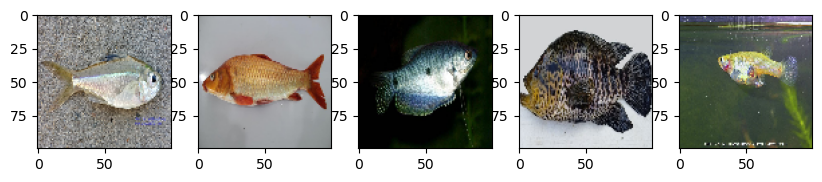

In [11]:
show_img(sources)

75.84437499999999


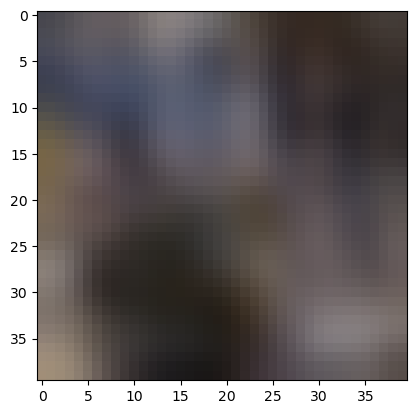

In [12]:
center = sources[3][30:70, 30:70]
center = cv2.GaussianBlur(center,(11,11),0)
# center =cv2.cvtColor(center)
plt.imshow(center,'gray')
print(center.mean(0).mean(0).mean(0))

In [13]:

def wrap_padding(src: np.ndarray, size=1) -> np.ndarray:
    src_x, src_y = src.shape
    result = np.zeros((src_x+(size*2),src_y+(size*2)))

    # wrap padding corner
    result[:-size*2, :-size*2] = src
    result[size*2:, :-size*2] = src
    result[size*2:, size*2:] = src
    result[:-size*2, size*2:] = src
    # wrap padding lrtb
    result[:-size*2, size:-size] = src
    result[size*2:, size:-size] = src
    result[size:-size, size*2:] = src
    result[size:-size, :-size*2] = src
    
    # center
    result[size:-size, size:-size] = src
    return result

def median_filter(src: np.ndarray, size=3):
    src_pad = np.pad(src, (size-1)//2, "wrap")
    x_axis, y_axis = src.shape
    result = np.zeros_like(src)
    for y in range(y_axis):
        for x in range(x_axis):
            m33 = src_pad[x : x + size, y : y + size]
            flat = np.sort(m33.flatten())
            result[x, y] = flat[(flat.size+1)//2]
    return result

# filter mean a.k.a blur
def mean_filter(src:np.ndarray, size = 3):
    src_pad = wrap_padding(src, (size-1)//2)
    x_axis, y_axis = src.shape
    result = np.zeros_like(src)
    for y in range(y_axis):
        for x in range(x_axis):
            m33 = src_pad[x : x + size, y : y + size]
            flat = (m33.sum()) / m33.size
            result[x, y] = flat
    return result

In [14]:
kernel = np.array([
    [1,1,1],
    [1,1,1],
    [1,1,1],
]
)
def padding(citra: np.ndarray):
    xcitra, ycitra = citra.shape
    xkernel, ykernel = kernel.shape
    out = np.zeros((xcitra+xkernel-1, ycitra+ykernel-1))
    out[xkernel//2:-(xkernel//2),ykernel//2:-(ykernel//2)] = citra
    return out

def erosi(citra:np.ndarray):
    xkernel, ykernel = kernel.shape
    #kernel sum
    ksum = kernel.sum() * citra.max()
    src = padding(citra)
    result = np.zeros(citra.shape)
    for y in range(citra.shape[1]):
        for x in range(citra.shape[0]):
            temp = src[x:x+xkernel, y:y+ykernel]
            if temp.size != kernel.size:
                continue
            temp_sum = (temp * kernel).sum()
            if(temp_sum == ksum):
                result[x,y] = 1

    return result

def dilasi(citra:np.ndarray):
    xkernel, ykernel = kernel.shape
    src = padding(citra)
    result = np.zeros(citra.shape)
    for y in range(citra.shape[1]):
        for x in range(citra.shape[0]):
            temp = src[x:x+xkernel, y:y+ykernel]
            if temp.size != kernel.size:
                continue
            temp_sum = (temp * kernel).sum()
            if(temp_sum != 0):
                result[x,y] = 1
  
    return result

def opening(citra: np.ndarray):
    t = erosi(citra)
    return dilasi(t)

In [15]:
def normalize(src: np.ndarray, max:int = 255):
    vmin, vmax = src.min(), src.max()
    temp = np.array(((src - vmin)/ (vmax - vmin)) * max, dtype=np.float32)
    return np.array(temp,np.int64)

In [16]:
def mask_fish(image):
    # Preprocess
    
    src = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #center image
    center = src[30:70, 30:70]
    center = mean_filter(center,7)
    
    #image 
    #blur with mean filter
    src = mean_filter(src,7)
    #median filter
    src = median_filter(src,5)

    # get mean
    mean = np.mean(src)
    mean_center = np.mean(center)
    # print(f"all: {mean}, center: {mean_center}")

    # Thresholding based on background color
    if mean < mean_center:
        # if avg color is black
        _, mask = cv2.threshold(src, mean, 255, cv2.THRESH_BINARY)
    else:
        _, mask = cv2.threshold(src, mean+10, 255, cv2.THRESH_BINARY_INV)
    #opening
    mask = opening(mask)
    # plt.imshow(mask,'gray')
    mask = binary_fill_holes(mask).astype(np.uint8)
    # mask = np.stack([mask,mask,mask],2)
    masked_image = cv2.bitwise_and(image,image, mask=mask)
    masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    masked_image = normalize(masked_image)

    # plt.imshow(masked_image,'gray')
    return masked_image

min: 0 max: 255


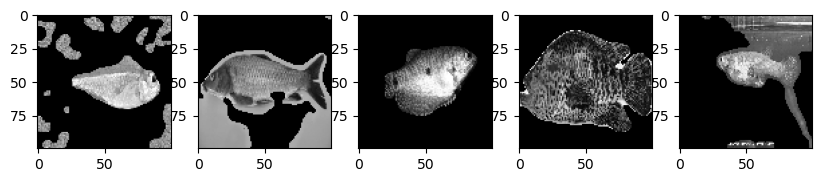

In [17]:
res = []
# _=mask_fish(sources[0])
for item in sources:
    res.append(mask_fish(item))
print(f"min: {res[0].min()} max: {res[0].max()}")
show_img(res)

# EKSTRAKSI CIRI TEKSTUR

In [18]:
from math import log, sqrt
err = []
def contrast(src:np.ndarray):
    xshape, yshape = src.shape
    out = 0
    for x in range(xshape):
        for y in range(yshape):
            try:
                out += src[x,y] * pow(x - y,2)
            except:
                err.append("error")
    return out

def homogeneity(image):
    result = 0
    for j in range(image.shape[0]):
        for k in range(image.shape[1]):
            result += image[j, k] / (1 + np.abs(j - k))
    return result

def dissimilarity(image):
    result = 0
    for j in range(image.shape[0]):
        for k in range(image.shape[1]):
            
            result += abs(j - k) * image[j, k]
    return result

def entropy(src):
    xshape, yshape = src.shape
    out = 0
    for x in range(xshape):
        for y in range(yshape):
            if src[x,y] > 0:
                out += src[x,y] * log(src[x,y],2) * -1
    return out

def asm(image):
    result = np.sum(np.square(image))
    return result

def energy(image):
    result = np.sqrt(asm(image))
    return result

def correlation(src):
    xshape, yshape = src.shape
    mean_x, mean_y, std_x, std_y,correlation = 0,0,0,0,0
    for x in range(xshape):
        for y in range(yshape):
            correlation += ((x+y) * src[x,y])
            mean_x += x * src[x,y]
            mean_y += y * src[x,y]
    for x in range(xshape):
        for y in range(yshape):
            std_x += src[x,y] * ((x - mean_x)**2)
            std_y += src[x,y] * ((y - mean_y)**2)
    std_x = sqrt(std_x)
    std_y = sqrt(std_y)
    if std_x != 0 and std_y != 0:
        correlation = (correlation - (mean_x * mean_y) / (std_x * std_y))
    return correlation

In [29]:
folders = {
    'perchlet': './resized-dataset/train/Glass Perchlet/',
    'gold': './resized-dataset/train/Gold Fish/',
    'gourami': './resized-dataset/train/Gourami/',
    'jaguar': './resized-dataset/train/Jaguar Gapote/',
    'mosquito': './resized-dataset/train/Mosquito Fish/'
}
folders_val = {
    'perchlet': './resized-dataset/val/Glass Perchlet/',
    'gold': './resized-dataset/val/Gold Fish/',
    'gourami': './resized-dataset/val/Gourami/',
    'jaguar': './resized-dataset/val/Jaguar Gapote/',
    'mosquito': './resized-dataset/val/Mosquito Fish/'
}

labels = {
    'perchlet': 0,
    'gold': 1,
    'gourami': 2,
    'jaguar': 3,
    'mosquito': 4
}
header = [
        'label',
        'contrast',
        'homogeneity',
        'dissimilarity',
        'entropy',
        'asm',
        'energy',
        'correlation'
]
header = [
        'label',
        'contrast0',
        'homogeneity0',
        'dissimilarity0',
        'entropy0',
        'asm0',
        'energy0',
        'correlation0',

        'contrast45',
        'homogeneity45',
        'dissimilarity45',
        'asm45',
        'energy45',
        'entropy45',
        'correlation45',

        'contrast90',
        'homogeneity90',
        'dissimilarity90',
        'entropy90',
        'asm90',
        'energy90',
        'correlation90',

        'contrast135',
        'homogeneity135',
        'dissimilarity135',
        'entropy135',
        'asm135',
        'energy135',
        'correlation135',
]

In [20]:
def extract(src: np.ndarray):
    res_x,res_y = (src.max()+1,src.max()+1)
    result1,result2,result3,result4 = np.zeros((res_x,res_y)),np.zeros((res_x,res_y)),np.zeros((res_x,res_y)),np.zeros((res_x,res_y))
    xshape, yshape = src.shape
    for x in range(xshape):
        for y in range(yshape):
            temp = src[x:x+2, y:y+2]
            if temp.shape[0] == 2:                
            # 0 derajat
                xPos, yPos = temp[0,0], temp[1,0]
                result1[xPos, yPos] += 1
                result1[yPos, xPos] += 1

            if temp.shape[1] == 2:                
            # 90 derajat
                xPos, yPos = temp[0,0], temp[0,1]
                result3[xPos, yPos] += 1
                result3[yPos, xPos] += 1
            
            if temp.shape == (2,2):                
            # 45 derajat
                xPos, yPos = temp[0,0], temp[1,1]
                result2[xPos, yPos] += 1
                result2[yPos, xPos] += 1

            # 135 derajat
                xPos, yPos = temp[1,0], temp[0,1]
                result4[xPos, yPos] += 1
                result4[yPos, xPos] += 1
    result1 += result1.transpose()
    result2 += result2.transpose()
    result3 += result3.transpose()
    result4 += result4.transpose()

    result1 = result1 / result1.sum()
    result2 = result2 / result2.sum()
    result3 = result3 / result3.sum()
    result4 = result4 / result4.sum()
    return result1,result2,result3,result4

In [21]:
def do_extraction_degree(image: np.ndarray):
    derajat = []
    a0,a45,a90,a135 = extract(image)
    derajat.append(a0)
    derajat.append(a45)
    derajat.append(a90)
    derajat.append(a135)
    return derajat

In [22]:
import concurrent.futures
def extract_texture(masked_image_grayscale):
    contrast_value = contrast(masked_image_grayscale)
    homogeneity_value = homogeneity(masked_image_grayscale)
    dissimilarity_value = dissimilarity(masked_image_grayscale)
    entropy_value = entropy(masked_image_grayscale)
    asm_value = asm(masked_image_grayscale)
    energy_value = energy(masked_image_grayscale)
    correlation_value = correlation(masked_image_grayscale)

    return [contrast_value, homogeneity_value, dissimilarity_value, entropy_value, asm_value, energy_value, correlation_value]

In [23]:
import threading
from tqdm.auto import tqdm
def do_extraction(folders: dict, destination: list):
    images_with_num = {}
    for path in folders:
        label_num = labels[path] # number label
        path = folders[path] # get folder path based on label key
        # load images in a folder / label
        images = importImages(path)
        images_with_num[label_num] = images

    for label,images in tqdm(images_with_num.items(), desc="Label"):
        # print(f"{label} with {image}")
        # return
        for image in tqdm(images, leave=False, desc="Individual IMG processing"):
            result = []
            masked_image = mask_fish(image)

            if masked_image is not None:
                d0, d45, d90, d135 = do_extraction_degree(masked_image)
                with concurrent.futures.ThreadPoolExecutor() as executor:
                    arr1 = executor.submit(extract_texture,d0)
                    arr2 = executor.submit(extract_texture,d45)
                    arr3 = executor.submit(extract_texture,d90)
                    arr4 = executor.submit(extract_texture,d135)
                arr = [label] + arr1.result() + arr2.result() + arr3.result() + arr4.result()
                result.append(arr)
            destination.append(result)

In [24]:
train_data = []
val_data = []
t1=threading.Thread(target=do_extraction, args=(folders, train_data)) 
t2=threading.Thread(target=do_extraction, args=(folders_val, val_data))
t1.start()
t2.start()
t1.join()
t2.join()

Label:   0%|          | 0/5 [00:00<?, ?it/s]

Individual IMG processing:   0%|          | 0/124 [00:00<?, ?it/s]

Label:   0%|          | 0/5 [00:00<?, ?it/s]

Individual IMG processing:   0%|          | 0/397 [00:00<?, ?it/s]

Individual IMG processing:   0%|          | 0/65 [00:00<?, ?it/s]

Individual IMG processing:   0%|          | 0/97 [00:00<?, ?it/s]

Individual IMG processing:   0%|          | 0/72 [00:00<?, ?it/s]

Individual IMG processing:   0%|          | 0/80 [00:00<?, ?it/s]

Individual IMG processing:   0%|          | 0/206 [00:00<?, ?it/s]

Individual IMG processing:   0%|          | 0/311 [00:00<?, ?it/s]

Individual IMG processing:   0%|          | 0/229 [00:00<?, ?it/s]

Individual IMG processing:   0%|          | 0/254 [00:00<?, ?it/s]

In [28]:
print(train_data[0])
print(err)

[[0, 1215.4750505050422, 0.7027646510808053, 12.95747474747475, 4.872979426211392, 0.44798775124987245, 0.6693188711293537, 101.91995264580517, 1639.2689521477394, 0.6903161864313216, 15.890725436179844, 4.9535417365784316, 0.43703660605460976, 0.6610874420639147, 101.94140383483447, 1076.1870707070452, 0.7040656683400102, 12.143030303030267, 4.832406458221564, 0.45259457708397116, 0.6727514972736747, 101.81857684901382, 1570.5390266299394, 0.6913129986054346, 15.420977451280299, 4.938274933878363, 0.43960019675701123, 0.6630235265486522, 101.94364686400712]]
[]


In [26]:
def save_to_csv(data:list, header: list, filename: str):
    with open(f'{filename}.csv','w',encoding="UTF8") as f:
        head = ','.join(header)
        f.write(head + "\n")
        for item in data:
            temp = []
            for data in item:
                temp.append(str(data))
            body = ','.join(temp)
            f.write(body + "\n")
        f.close()

In [27]:
save_to_csv(train_data, header, 'train_dataset')
save_to_csv(val_data, header, 'val_dataset')